In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import OrderedDict

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters

from models.activ_func import *
from models.Nets import *
from models.test import test_img
from models.Update import *

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser

import torchvision

%load_ext autoreload
%autoreload 2

In [2]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 1  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 1 #"the number of local epochs: E"
    local_bs  = 128  #"local batch size: B"
    bs        = 128 #"test batch size"
    lr        = 0.1 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    split     = 'user' # "train-test split type, user or sample"

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root="./data/cifar", train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=args.bs, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root="./data/cifar", train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=args.bs, shuffle=False, num_workers=2)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [19]:
net = ResNet18()
net.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [3]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

#         images.resize_(images.shape[0], 3*32*32)

        images = images.cuda()
        labels = labels.cuda()

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-4)
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

train_accuracy_relu = []
train_loss_relu = []
test_accuracy_relu  = []
test_loss_relu  = []


for epoch in range(100):
    
    if epoch <= 40:
        cur_lr = 0.001
    elif epoch <= 80:
        cur_lr = 0.0005
    else:    
        cur_lr = 0.0001
    
    for g in optimizer.param_groups:
        g['lr'] = cur_lr    
        
        
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if args.gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

#         if epoch > 16:
#             for group in optimizer.param_groups:
#                 for p in group['params']:
#                     state = optimizer.state[p]
#                     if state['step'] >= 1024:
#                         state['step'] = 1000
        optimizer.step()


        # print statistics
        if i % 100 == 0:
            print(i,loss.data)
        running_loss += loss.data

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    test_loss, test_accuracy = validation(net, testloader, criterion)
    train_loss, train_accuracy = validation(net, trainloader, criterion)

    print("Iteration: {0} | Loss: {1} |".format(epoch+1, running_loss),
          "Train,Test accuracy: {0}.3f%, {1}.3f%".format(train_accuracy/len(trainloader), test_accuracy/len(testloader)) )
    
    train_accuracy_relu.append(train_accuracy/len(trainloader))
    train_loss_relu.append(train_loss)
    
    test_accuracy_relu.append(test_accuracy/len(testloader))
    test_loss_relu.append(test_loss)
    
    # Specify a path
    PATH = "./save_models/CIFAR10_ResNet_relu_E100_iter"+str(epoch)+".pt"
    torch.save(net.state_dict(), PATH)

0 tensor(2.3904, device='cuda:0')
100 tensor(1.7751, device='cuda:0')
200 tensor(1.4119, device='cuda:0')
300 tensor(1.4050, device='cuda:0')
Iteration: 1 | Loss: 1.513360619544983 | Train,Test accuracy: 0.5785326361656189.3f%, 0.5356012582778931.3f%
0 tensor(1.2648, device='cuda:0')
100 tensor(1.0884, device='cuda:0')
200 tensor(0.9673, device='cuda:0')
300 tensor(0.9625, device='cuda:0')
Iteration: 2 | Loss: 1.0546351671218872 | Train,Test accuracy: 0.6551150679588318.3f%, 0.6389438509941101.3f%
0 tensor(0.9454, device='cuda:0')
100 tensor(0.8816, device='cuda:0')
200 tensor(0.8472, device='cuda:0')
300 tensor(0.7217, device='cuda:0')
Iteration: 3 | Loss: 0.850999653339386 | Train,Test accuracy: 0.7364130616188049.3f%, 0.710344135761261.3f%
0 tensor(0.7278, device='cuda:0')
100 tensor(0.5340, device='cuda:0')
200 tensor(0.8142, device='cuda:0')
300 tensor(0.5937, device='cuda:0')
Iteration: 4 | Loss: 0.7207249999046326 | Train,Test accuracy: 0.7810262441635132.3f%, 0.7582080960273743

Iteration: 33 | Loss: 0.2648182809352875 | Train,Test accuracy: 0.9160045981407166.3f%, 0.8702531456947327.3f%
0 tensor(0.2750, device='cuda:0')
100 tensor(0.1998, device='cuda:0')
200 tensor(0.2366, device='cuda:0')
300 tensor(0.3150, device='cuda:0')
Iteration: 34 | Loss: 0.2592785954475403 | Train,Test accuracy: 0.9198769330978394.3f%, 0.858781635761261.3f%
0 tensor(0.1901, device='cuda:0')
100 tensor(0.1855, device='cuda:0')
200 tensor(0.2822, device='cuda:0')
300 tensor(0.2337, device='cuda:0')
Iteration: 35 | Loss: 0.25540676712989807 | Train,Test accuracy: 0.9182824492454529.3f%, 0.863132894039154.3f%
0 tensor(0.3625, device='cuda:0')
100 tensor(0.2484, device='cuda:0')
200 tensor(0.2646, device='cuda:0')
300 tensor(0.3124, device='cuda:0')
Iteration: 36 | Loss: 0.2568017840385437 | Train,Test accuracy: 0.9229819178581238.3f%, 0.8667919039726257.3f%
0 tensor(0.1566, device='cuda:0')
100 tensor(0.2770, device='cuda:0')
200 tensor(0.3121, device='cuda:0')
300 tensor(0.2774, device

0 tensor(0.0828, device='cuda:0')
100 tensor(0.0642, device='cuda:0')
200 tensor(0.1333, device='cuda:0')
300 tensor(0.1619, device='cuda:0')
Iteration: 66 | Loss: 0.12289293110370636 | Train,Test accuracy: 0.9593949913978577.3f%, 0.8809335231781006.3f%
0 tensor(0.0576, device='cuda:0')
100 tensor(0.1429, device='cuda:0')
200 tensor(0.0981, device='cuda:0')
300 tensor(0.2289, device='cuda:0')
Iteration: 67 | Loss: 0.12259691208600998 | Train,Test accuracy: 0.9634190797805786.3f%, 0.8783623576164246.3f%
0 tensor(0.0903, device='cuda:0')
100 tensor(0.1221, device='cuda:0')
200 tensor(0.1317, device='cuda:0')
300 tensor(0.1135, device='cuda:0')
Iteration: 68 | Loss: 0.12221794575452805 | Train,Test accuracy: 0.96365886926651.3f%, 0.8830102682113647.3f%
0 tensor(0.0788, device='cuda:0')
100 tensor(0.1257, device='cuda:0')
200 tensor(0.1085, device='cuda:0')
300 tensor(0.1685, device='cuda:0')
Iteration: 69 | Loss: 0.12047243118286133 | Train,Test accuracy: 0.9638307094573975.3f%, 0.8833069

300 tensor(0.0125, device='cuda:0')
Iteration: 98 | Loss: 0.024556340649724007 | Train,Test accuracy: 0.9929667711257935.3f%, 0.8971518874168396.3f%
0 tensor(0.0482, device='cuda:0')
100 tensor(0.0072, device='cuda:0')
200 tensor(0.0280, device='cuda:0')
300 tensor(0.0133, device='cuda:0')
Iteration: 99 | Loss: 0.02274768054485321 | Train,Test accuracy: 0.9933463931083679.3f%, 0.8929983973503113.3f%
0 tensor(0.0313, device='cuda:0')
100 tensor(0.0184, device='cuda:0')
200 tensor(0.0255, device='cuda:0')
300 tensor(0.0112, device='cuda:0')
Iteration: 100 | Loss: 0.02176293544471264 | Train,Test accuracy: 0.9940657019615173.3f%, 0.8908227682113647.3f%


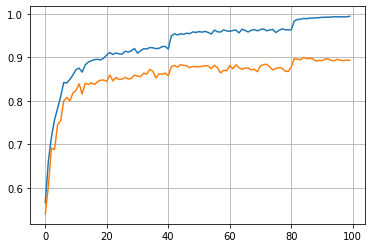

In [34]:
import pickle
import matplotlib.pyplot as plt

plt.plot(train_accuracy_relu)
plt.plot(test_accuracy_relu)
plt.grid()
plt.show()

# 1.2. ResNet with Relu, without Batch normalization

In [22]:
net = ResNet18_without_BN()
net.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock_without_BN(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential()
    )
    (1): BasicBlock_without_BN(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock_without_BN(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential(
  

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-4)

train_accuracy_relu_without_BN = []
train_loss_relu_without_BN = []
test_accuracy_relu_without_BN  = []
test_loss_relu_without_BN  = []


for epoch in range(100):
    
    if epoch <= 40:
        cur_lr = 0.001
    elif epoch <= 80:
        cur_lr = 0.0005
    else:    
        cur_lr = 0.0001
    
    for g in optimizer.param_groups:
        g['lr'] = cur_lr  
        
        
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if args.gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        if epoch > 16:
            for group in optimizer.param_groups:
                for p in group['params']:
                    state = optimizer.state[p]
                    if state['step'] >= 1024:
                        state['step'] = 1000
        optimizer.step()


        # print statistics
        if i % 100 == 0:
            print(i,loss.data)
        running_loss += loss.data

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    test_loss, test_accuracy = validation(net, testloader, criterion)
    train_loss, train_accuracy = validation(net, trainloader, criterion)

    print("Iteration: {0} | Loss: {1} |".format(epoch+1, running_loss),
          "Train,Test accuracy: {0}.3f%, {1}.3f%".format(train_accuracy/len(trainloader), test_accuracy/len(testloader)) )
    
    train_accuracy_relu_without_BN.append(train_accuracy/len(trainloader))
    train_loss_relu_without_BN.append(train_loss)
    
    test_accuracy_relu_without_BN.append(test_accuracy/len(testloader))
    test_loss_relu_without_BN.append(test_loss)
    
    # Specify a path
    PATH = "./save_models/CIFAR10_ResNet18_withoutBN_relu_E100_iter"+str(epoch)+".pt"
    torch.save(net.state_dict(), PATH)

0 tensor(2.3002, device='cuda:0')
100 tensor(2.0122, device='cuda:0')
200 tensor(1.8866, device='cuda:0')
300 tensor(1.6736, device='cuda:0')
Iteration: 1 | Loss: 1.882279872894287 | Train,Test accuracy: 0.4230458736419678.3f%, 0.4185126721858978.3f%
0 tensor(1.6052, device='cuda:0')
100 tensor(1.5431, device='cuda:0')
200 tensor(1.2251, device='cuda:0')
300 tensor(1.4099, device='cuda:0')
Iteration: 2 | Loss: 1.386042833328247 | Train,Test accuracy: 0.5573609471321106.3f%, 0.5198773741722107.3f%
0 tensor(1.0858, device='cuda:0')
100 tensor(1.1559, device='cuda:0')
200 tensor(1.1023, device='cuda:0')
300 tensor(1.0276, device='cuda:0')
Iteration: 3 | Loss: 1.1215307712554932 | Train,Test accuracy: 0.6159287095069885.3f%, 0.543710470199585.3f%
0 tensor(1.0411, device='cuda:0')
100 tensor(0.7947, device='cuda:0')
200 tensor(0.7283, device='cuda:0')
300 tensor(0.9971, device='cuda:0')
Iteration: 4 | Loss: 0.9620018601417542 | Train,Test accuracy: 0.6915481686592102.3f%, 0.659414529800415.

Iteration: 33 | Loss: 0.30358046293258667 | Train,Test accuracy: 0.9010549783706665.3f%, 0.8687697649002075.3f%
0 tensor(0.3788, device='cuda:0')
100 tensor(0.2691, device='cuda:0')
200 tensor(0.3292, device='cuda:0')
300 tensor(0.3666, device='cuda:0')
Iteration: 34 | Loss: 0.30010712146759033 | Train,Test accuracy: 0.9082919955253601.3f%, 0.8586827516555786.3f%
0 tensor(0.1825, device='cuda:0')
100 tensor(0.3116, device='cuda:0')
200 tensor(0.4069, device='cuda:0')
300 tensor(0.2104, device='cuda:0')
Iteration: 35 | Loss: 0.29941657185554504 | Train,Test accuracy: 0.909307062625885.3f%, 0.8627373576164246.3f%
0 tensor(0.2189, device='cuda:0')
100 tensor(0.2284, device='cuda:0')
200 tensor(0.2347, device='cuda:0')
300 tensor(0.1830, device='cuda:0')
Iteration: 36 | Loss: 0.2895475924015045 | Train,Test accuracy: 0.8940976858139038.3f%, 0.8356408476829529.3f%
0 tensor(0.3782, device='cuda:0')
100 tensor(0.2671, device='cuda:0')
200 tensor(0.2741, device='cuda:0')
300 tensor(0.2607, dev

0 tensor(0.1069, device='cuda:0')
100 tensor(0.0826, device='cuda:0')
200 tensor(0.1625, device='cuda:0')
300 tensor(0.0937, device='cuda:0')
Iteration: 66 | Loss: 0.14860473573207855 | Train,Test accuracy: 0.9542039632797241.3f%, 0.8820213675498962.3f%
0 tensor(0.1454, device='cuda:0')
100 tensor(0.1030, device='cuda:0')
200 tensor(0.1772, device='cuda:0')
300 tensor(0.1618, device='cuda:0')
Iteration: 67 | Loss: 0.1472269892692566 | Train,Test accuracy: 0.9522178769111633.3f%, 0.8891416192054749.3f%
0 tensor(0.2264, device='cuda:0')
100 tensor(0.1019, device='cuda:0')
200 tensor(0.1605, device='cuda:0')
300 tensor(0.1179, device='cuda:0')
Iteration: 68 | Loss: 0.14889493584632874 | Train,Test accuracy: 0.9582080841064453.3f%, 0.8804391026496887.3f%
0 tensor(0.1026, device='cuda:0')
100 tensor(0.1444, device='cuda:0')
200 tensor(0.1760, device='cuda:0')
300 tensor(0.1155, device='cuda:0')
Iteration: 69 | Loss: 0.14548876881599426 | Train,Test accuracy: 0.9560182094573975.3f%, 0.892602

300 tensor(0.0834, device='cuda:0')
Iteration: 98 | Loss: 0.04837577044963837 | Train,Test accuracy: 0.9826046824455261.3f%, 0.899624228477478.3f%
0 tensor(0.0344, device='cuda:0')
100 tensor(0.0372, device='cuda:0')
200 tensor(0.0333, device='cuda:0')
300 tensor(0.0307, device='cuda:0')
Iteration: 99 | Loss: 0.04672820866107941 | Train,Test accuracy: 0.9848345518112183.3f%, 0.8987341523170471.3f%
0 tensor(0.0272, device='cuda:0')
100 tensor(0.0277, device='cuda:0')
200 tensor(0.0753, device='cuda:0')
300 tensor(0.0209, device='cuda:0')
Iteration: 100 | Loss: 0.04571510851383209 | Train,Test accuracy: 0.9840033054351807.3f%, 0.8989319801330566.3f%


# 2. Resnet Poly (=X^2 + x)

In [4]:
from torch.nn import Module
import torch.nn.functional as F
import brevitas.nn as qnn
from brevitas.core.quant import QuantType


bit_width_sel = 8

class BasicBlock_QPoly(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock_QPoly, self).__init__()
        self.conv1 = qnn.QuantConv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False, weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.bn1 = nn.BatchNorm2d(planes)
        self.activ1 = qnn.QuantXsquare2(quant_type=QuantType.INT, bit_width=bit_width_sel, max_val=6)
        self.conv2 = qnn.QuantConv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False, weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.bn2 = nn.BatchNorm2d(planes)
        self.activ2 = self.activ1 = qnn.QuantXsquare2(quant_type=QuantType.INT, bit_width=bit_width_sel, max_val=6)
    
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                qnn.QuantConv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False, weight_quant_type=QuantType.INT, weight_bit_width=8),
#                 nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
#         out = self.activ1(self.conv1(x))
        out = self.activ1(self.bn1(self.conv1(x)))
        out = self.conv2(out)
#         out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.activ2(out)
        return out

class ResNet_QPoly(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_QPoly, self).__init__()
        self.in_planes = 64

        self.conv1 = qnn.QuantConv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False, weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.activ = qnn.QuantXsquare2(quant_type=QuantType.INT, bit_width=bit_width_sel, max_val=6)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.activ(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18_QPoly():
    return ResNet_QPoly(BasicBlock_QPoly, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [5]:
lr_array = [0.01, 0.0001,0.5]
# weight_decay_ = 5e-3
weight_decay_ = 5e-4
# weight_decay_ = 5e-5


train_accuracy_qPoly_arr = []
train_loss_qPoly_arr = []
test_accuracy_qPoly_arr  = []
test_loss_qPoly_arr  = []

for i in range(len(lr_array)):
    
    lr_tmp = lr_array[i]
    
    net = ResNet18_QPoly()
    net.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr_tmp, weight_decay=weight_decay_)

    train_accuracy_qPoly = []
    train_loss_qPoly = []
    test_accuracy_qPoly  = []
    test_loss_qPoly  = []

    for epoch in range(30):

        if epoch <= 40:
            cur_lr = 0.001
        elif epoch <= 80:
            cur_lr = 0.0005
        else:    
            cur_lr = 0.0001

        for g in optimizer.param_groups:
            g['lr'] = cur_lr  


        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            if args.gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

    #         if epoch > 16:
    #             for group in optimizer.param_groups:
    #                 for p in group['params']:
    #                     state = optimizer.state[p]
    #                     if state['step'] >= 1024:
    #                         state['step'] = 1000
    #         optimizer.step()


            # print statistics
            if i % 100 == 0:
                print(i,loss.data)
            running_loss += loss.data

        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)

        # Calculate training/test set accuracy of the existing model
        test_loss, test_accuracy = validation(net, testloader, criterion)
        train_loss, train_accuracy = validation(net, trainloader, criterion)

        print("Iteration: {0} | Loss: {1} |".format(epoch+1, running_loss),
              "Train,Test accuracy: {0}.3f%, {1}.3f%".format(train_accuracy/len(trainloader), test_accuracy/len(testloader)) )

        train_accuracy_qPoly.append(train_accuracy/len(trainloader))
        train_loss_qPoly.append(train_loss)

        test_accuracy_qPoly.append(test_accuracy/len(testloader))
        test_loss_qPoly.append(test_loss)

        # Specify a path
#         PATH = "./save_models/CIFAR10_ResNet18_qPoly_E100_iter"+str(epoch)+".pt"
#         torch.save(net.state_dict(), PATH)
    train_accuracy_qPoly_arr.append(train_accuracy_qPoly)
    train_loss_qPoly_arr.append(train_loss_qPoly)
    test_accuracy_qPoly_arr.append(test_accuracy_qPoly)
    test_loss_qPoly_arr.append(test_loss_qPoly)

c:\programdata\anaconda3\lib\site-packages\torch\jit\_recursive.py:159: UserWarning: 'stats_reduce_dim' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))
c:\programdata\anaconda3\lib\site-packages\torch\jit\_recursive.py:159: UserWarning: 'const_affine_weight' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))
c:\programdata\anaconda3\lib\site-packages\torch\jit\_recursive.py:159: UserWarning: 'const_affine_bias' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))


0 tensor(4.5943, device='cuda:0')
100 tensor(4.5538, device='cuda:0')
200 tensor(4.4815, device='cuda:0')
300 tensor(4.6323, device='cuda:0')
Iteration: 1 | Loss: 4.497351169586182 | Train,Test accuracy: 0.09940057247877121.3f%, 0.09909018874168396.3f%
0 tensor(4.4681, device='cuda:0')
100 tensor(4.3418, device='cuda:0')
200 tensor(4.5051, device='cuda:0')
300 tensor(4.3771, device='cuda:0')
Iteration: 2 | Loss: 4.496448040008545 | Train,Test accuracy: 0.09947650134563446.3f%, 0.09909018874168396.3f%
0 tensor(4.6131, device='cuda:0')
100 tensor(4.3582, device='cuda:0')
200 tensor(4.1129, device='cuda:0')
300 tensor(4.3152, device='cuda:0')
Iteration: 3 | Loss: 4.496376991271973 | Train,Test accuracy: 0.0992886871099472.3f%, 0.09909018874168396.3f%
0 tensor(4.2786, device='cuda:0')
100 tensor(4.2969, device='cuda:0')
200 tensor(4.5087, device='cuda:0')
300 tensor(4.4781, device='cuda:0')
Iteration: 4 | Loss: 4.497702121734619 | Train,Test accuracy: 0.09980018436908722.3f%, 0.09909018874

300 tensor(3.7012, device='cuda:0')
Iteration: 3 | Loss: 3.8843462467193604 | Train,Test accuracy: 0.10004796087741852.3f%, 0.10096914321184158.3f%
0 tensor(3.8488, device='cuda:0')
100 tensor(3.9558, device='cuda:0')
200 tensor(4.1561, device='cuda:0')
300 tensor(3.8265, device='cuda:0')
Iteration: 4 | Loss: 3.882432460784912 | Train,Test accuracy: 0.10005994141101837.3f%, 0.10096914321184158.3f%
0 tensor(4.0885, device='cuda:0')
100 tensor(3.8596, device='cuda:0')
200 tensor(4.0114, device='cuda:0')
300 tensor(3.6475, device='cuda:0')
Iteration: 5 | Loss: 3.883322238922119 | Train,Test accuracy: 0.09999999403953552.3f%, 0.10096914321184158.3f%
0 tensor(3.7064, device='cuda:0')
100 tensor(3.8636, device='cuda:0')
200 tensor(3.8420, device='cuda:0')
300 tensor(3.8146, device='cuda:0')
Iteration: 6 | Loss: 3.883700132369995 | Train,Test accuracy: 0.10003596544265747.3f%, 0.10096914321184158.3f%
0 tensor(3.8298, device='cuda:0')
100 tensor(3.7871, device='cuda:0')
200 tensor(4.0109, devi

0 tensor(3.6434, device='cuda:0')
100 tensor(3.4387, device='cuda:0')
200 tensor(3.4319, device='cuda:0')
300 tensor(3.5115, device='cuda:0')
Iteration: 6 | Loss: 3.5320420265197754 | Train,Test accuracy: 0.09944853186607361.3f%, 0.10225474834442139.3f%
0 tensor(3.3246, device='cuda:0')
100 tensor(3.4627, device='cuda:0')
200 tensor(3.4994, device='cuda:0')
300 tensor(3.7238, device='cuda:0')
Iteration: 7 | Loss: 3.5274758338928223 | Train,Test accuracy: 0.0992167517542839.3f%, 0.10225474834442139.3f%
0 tensor(3.6775, device='cuda:0')
100 tensor(3.5979, device='cuda:0')
200 tensor(3.2998, device='cuda:0')
300 tensor(3.3171, device='cuda:0')
Iteration: 8 | Loss: 3.5291860103607178 | Train,Test accuracy: 0.09983615577220917.3f%, 0.10225474834442139.3f%
0 tensor(3.3307, device='cuda:0')
100 tensor(3.5831, device='cuda:0')
200 tensor(3.5725, device='cuda:0')
300 tensor(3.2491, device='cuda:0')
Iteration: 9 | Loss: 3.5292930603027344 | Train,Test accuracy: 0.09948049485683441.3f%, 0.1022547

# 3. ResNet Quad (=x^2)

In [34]:
from torch.nn import Module
import torch.nn.functional as F
import brevitas.nn as qnn
from brevitas.core.quant import QuantType


bit_width_sel = 8

class BasicBlock_Quad(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock_Quad, self).__init__()
        self.conv1 = qnn.QuantConv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False, weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.bn1 = nn.BatchNorm2d(planes)
        self.activ1 = qnn.QuantXsquare(quant_type=QuantType.INT, bit_width=bit_width_sel, max_val=6)
        self.conv2 = qnn.QuantConv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False, weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.bn2 = nn.BatchNorm2d(planes)
        self.activ2 = self.activ1 = qnn.QuantXsquare2(quant_type=QuantType.INT, bit_width=bit_width_sel, max_val=6)
    
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                qnn.QuantConv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False, weight_quant_type=QuantType.INT, weight_bit_width=8),
#                 nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
#         out = self.activ1(self.conv1(x))
        out = self.activ1(self.bn1(self.conv1(x)))
        out = self.conv2(out)
#         out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.activ2(out)
        return out

class ResNet_Quad(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_Quad, self).__init__()
        self.in_planes = 64

        self.conv1 = qnn.QuantConv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False, weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.activ = qnn.QuantXsquare(quant_type=QuantType.INT, bit_width=bit_width_sel, max_val=6)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.activ(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18_Quad():
    return ResNet_QPoly(BasicBlock_Quad, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [40]:
net = ResNet18_Quad()
net.cuda()

ResNet_QPoly(
  (conv1): QuantConv2d(
    3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (weight_reg): WeightReg()
    (weight_quant): WeightQuantProxy(
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RestrictValue(
            (forward_impl): RecursiveScriptModule(
              original_name=Sequential
              (0): RoundSte()
              (1): Identity()
            )
          )
          (tensor_clamp_impl): TensorClampSte()
        )
        (scaling_impl): ParameterStatsScaling(
          (parameter_list_stats): ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper()
            (stats): Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_impl): StatsScaling(
            (affine_rescaling): Identity()
            (restrict_scaling): RestrictValue(
              (forward_impl): RecursiveScriptModule(
                original_name

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-4)

train_accuracy_Quad = []
train_loss_Quad = []
test_accuracy_Quad  = []
test_loss_Quad  = []


for epoch in range(100):
    
    if epoch <= 40:
        cur_lr = 0.001
    elif epoch <= 80:
        cur_lr = 0.0005
    else:    
        cur_lr = 0.0001
    
    for g in optimizer.param_groups:
        g['lr'] = cur_lr  
        
        
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if args.gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

#         if epoch > 16:
#             for group in optimizer.param_groups:
#                 for p in group['params']:
#                     state = optimizer.state[p]
#                     if state['step'] >= 1024:
#                         state['step'] = 1000
#         optimizer.step()


        # print statistics
        if i % 100 == 0:
            print(i,loss.data)
        running_loss += loss.data

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    test_loss, test_accuracy = validation(net, testloader, criterion)
    train_loss, train_accuracy = validation(net, trainloader, criterion)

    print("Iteration: {0} | Loss: {1} |".format(epoch+1, running_loss),
          "Train,Test accuracy: {0}.3f%, {1}.3f%".format(train_accuracy/len(trainloader), test_accuracy/len(testloader)) )
    
    train_accuracy_Quad.append(train_accuracy/len(trainloader))
    train_loss_Quad.append(train_loss)
    
    test_accuracy_Quad.append(test_accuracy/len(testloader))
    test_loss_Quad.append(test_loss)
    
    # Specify a path
    PATH = "./save_models/CIFAR10_ResNet18_Quad_E100_iter"+str(epoch)+".pt"
    torch.save(net.state_dict(), PATH)

0 tensor(3.6528, device='cuda:0')
100 tensor(3.4006, device='cuda:0')
200 tensor(3.4432, device='cuda:0')
300 tensor(3.6369, device='cuda:0')
Iteration: 1 | Loss: 3.576638698577881 | Train,Test accuracy: 0.1039881706237793.3f%, 0.10185917466878891.3f%
0 tensor(3.5408, device='cuda:0')
100 tensor(3.9285, device='cuda:0')
200 tensor(3.4338, device='cuda:0')
300 tensor(3.5818, device='cuda:0')
Iteration: 2 | Loss: 3.5787711143493652 | Train,Test accuracy: 0.10262148082256317.3f%, 0.10185917466878891.3f%
0 tensor(3.4169, device='cuda:0')
100 tensor(3.8359, device='cuda:0')
200 tensor(3.7392, device='cuda:0')
300 tensor(3.4522, device='cuda:0')
Iteration: 3 | Loss: 3.575352668762207 | Train,Test accuracy: 0.10563059896230698.3f%, 0.10185917466878891.3f%
0 tensor(3.4248, device='cuda:0')
100 tensor(3.6050, device='cuda:0')


KeyboardInterrupt: 

In [33]:
import pickle

filehandler = open("./plot/CIFAR10_ResNet18_ReLU_train","wb")
pickle.dump(train_accuracy_relu,filehandler)

filehandler = open("./plot/CIFAR10_ResNet18_ReLU_test","wb")
pickle.dump(test_accuracy_relu,filehandler)

filehandler = open("./plot/CIFAR10_ResNet18_ReLU_withoutBN_train","wb")
pickle.dump(train_accuracy_relu_without_BN,filehandler)

filehandler = open("./plot/CIFAR10_ResNet18_ReLU_withoutBN_test","wb")
pickle.dump(test_accuracy_relu_without_BN,filehandler)

filehandler = open("./plot/CIFAR10_ResNet18_Poly_train","wb")
pickle.dump(train_accuracy_qPoly,filehandler)

filehandler = open("./plot/CIFAR10_ResNet18_Poly_test","wb")
pickle.dump(test_accuracy_qPoly,filehandler)

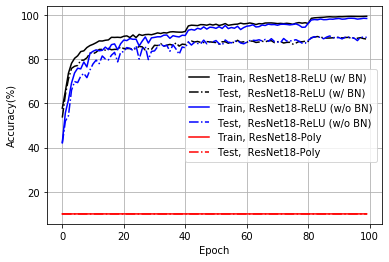

In [30]:
import pickle
import matplotlib.pyplot as plt
import matplotlib

# train_accuracy_Relu = pickle.load(open('./plot/CIFAR10_CNN_ReLU_v2_train','rb'))
# test_accuracy_Relu = pickle.load(open('./plot/CIFAR10_CNN_ReLU_v2_test','rb'))

# train_accuracy_qXsquare2 = pickle.load(open('./plot/CIFAR10_NiN_Poly_v1_train','rb'))
# test_accuracy_qXsquare2 = pickle.load(open('./plot/CIFAR10_NiN_Poly_v1_test','rb'))

# train_accuracy_qXsquare = pickle.load(open('./plot/CIFAR10_CNN_Xsq_train','rb'))
# test_accuracy_qXsquare = pickle.load(open('./plot/CIFAR10_CNN_Xsq_test','rb'))


stt_pos = 0
end_pos = 100

# print(test_accuracy_Relu[49], test_accuracy_Relu[end_pos-1])
# print(test_accuracy_qXsquare2[49], test_accuracy_qXsquare2[end_pos-1])
# print(test_accuracy_qXsquare[49],  test_accuracy_qXsquare[end_pos-1])

plt.plot(np.array(train_accuracy_relu[stt_pos:end_pos])*100,'k')
plt.plot(np.array(test_accuracy_relu[stt_pos:end_pos])*100,'k',linestyle='-.')

plt.plot(np.array(train_accuracy_relu_without_BN[stt_pos:end_pos])*100,'b')
plt.plot(np.array(test_accuracy_relu_without_BN[stt_pos:end_pos])*100,'b',linestyle='-.')

plt.plot(np.array(train_accuracy_qPoly[stt_pos:end_pos])*100,'r')
plt.plot(np.array(test_accuracy_qPoly[stt_pos:end_pos])*100,'r',linestyle='-.')

# plt.plot(np.array(train_accuracy_qXsquare[stt_pos:end_pos])*100+3,'b')
# plt.plot(np.array(test_accuracy_qXsquare[stt_pos:end_pos])*100+3,'b',linestyle='-.')


# plt.plot(acc_Brea,'b')
# plt.plot(acc_FedAvg_,'b',linestyle='-.')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')

plt.legend(['Train, ResNet18-ReLU (w/ BN)','Test,  ResNet18-ReLU (w/ BN)','Train, ResNet18-ReLU (w/o BN)','Test,  ResNet18-ReLU (w/o BN)','Train, ResNet18-Poly','Test,  ResNet18-Poly']) # ,'Train, CNN-Quad','Test,  CNN-Quad'
plt.savefig('./plot/accuracy_ResNet_CIFAR10_E'+str(end_pos)+'.png',dpi=300)
plt.show()